# Time series Forecasting using LSTM

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from keras.layers import ConvLSTM2D
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
path = 'D:/Datasets/flood dataset - kaggle/flood prediction/datasets_1686_3183_rainfall in india 1901-2015.csv'
dataframe = pd.read_csv(path, na_values=['na', '--'])
dataframe.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,ANDAMAN & NICOBAR ISLANDS,1901,49.2,87.1,29.2,2.3,528.8,517.5,365.1,481.1,332.6,388.5,558.2,33.6,3373.2,136.3,560.3,1696.3,980.3
1,ANDAMAN & NICOBAR ISLANDS,1902,0.0,159.8,12.2,0.0,446.1,537.1,228.9,753.7,666.2,197.2,359.0,160.5,3520.7,159.8,458.3,2185.9,716.7
2,ANDAMAN & NICOBAR ISLANDS,1903,12.7,144.0,0.0,1.0,235.1,479.9,728.4,326.7,339.0,181.2,284.4,225.0,2957.4,156.7,236.1,1874.0,690.6
3,ANDAMAN & NICOBAR ISLANDS,1904,9.4,14.7,0.0,202.4,304.5,495.1,502.0,160.1,820.4,222.2,308.7,40.1,3079.6,24.1,506.9,1977.6,571.0
4,ANDAMAN & NICOBAR ISLANDS,1905,1.3,0.0,3.3,26.9,279.5,628.7,368.7,330.5,297.0,260.7,25.4,344.7,2566.7,1.3,309.7,1624.9,630.8


In [4]:
# Filling NULL with mean of each values of column, because nun values will cause error in the following way
dataframe['JAN'].fillna((dataframe['JAN'].mean()), inplace=True)
dataframe['FEB'].fillna((dataframe['FEB'].mean()), inplace=True)
dataframe['MAR'].fillna((dataframe['MAR'].mean()), inplace=True)
dataframe['APR'].fillna((dataframe['APR'].mean()), inplace=True)
dataframe['MAY'].fillna((dataframe['MAY'].mean()), inplace=True)
dataframe['JUN'].fillna((dataframe['JUN'].mean()), inplace=True)
dataframe['JUL'].fillna((dataframe['JUL'].mean()), inplace=True)
dataframe['AUG'].fillna((dataframe['AUG'].mean()), inplace=True)
dataframe['SEP'].fillna((dataframe['SEP'].mean()), inplace=True)
dataframe['OCT'].fillna((dataframe['OCT'].mean()), inplace=True)
dataframe['DEC'].fillna((dataframe['DEC'].mean()), inplace=True)

In [21]:
# Here, each month has been separated into a column with its value
df_month = pd.DataFrame(dataframe[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL','AUG', 'SEP', 'OCT']])
df_month = df_month.T
df_month = df_month.unstack(level=0)
df_month = df_month.reset_index()

# Creation of year/month in a separate column
df_time = pd.Series(pd.period_range(start='1901', end='2016', freq='M', periods=None), dtype=str)
df_time = df_time.reset_index()

# To create a new datafarame which record the values of rainfall in the specific year and moth
df = pd.DataFrame({'Month':df_time[0],
                   'Rainfall':df_month[0]})
# To save pandas
df.to_csv("D:/rainfalDataset.csv")

display(df.head())
display(df.dtypes)

,Month,Rainfall
0,1901-01,49.2
1,1901-02,87.1
2,1901-03,29.2
3,1901-04,2.3
4,1901-05,528.8


Month        object
Rainfall    float64
dtype: object

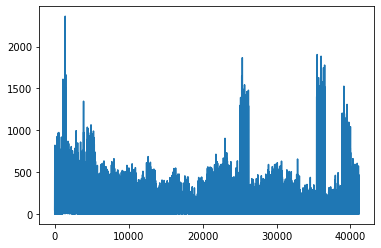

In [29]:
# Load the dataset
data = pd.read_csv("D:/rainfalDataset.csv", usecols=[1])
plt.plot(data)
plt.show()

In [40]:
# Convert pandas dataframe to numpy array
dataset = data.values
dataset = dataset.astype('float32')
dataset.shape

(41160, 1)

In [41]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
print(dataset)

[[0.02082275]
 [0.03686304]
 [0.01235822]
 ...
 [0.06196038]
 [0.06788556]
 [0.07000169]]


In [42]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset)*0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(train.shape)
print(test.shape)

(28811, 1)
(12349, 1)


In [72]:
# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []
    
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x), np.array(y)

# Number of time steps to look back 
seq_size = 10

# Split train and test
Train_x, Train_y = to_sequences(train, seq_size)
Test_x, Test_y = to_sequences(test, seq_size)

print("Shape of training set: {}".format(Train_x.shape))
print("Shape of test set: {}".format(Test_x.shape))

Shape of training set: (28800, 10)
Shape of test set: (12338, 10)


In [58]:
# Reshape input to be [samples, time_steps, features]
train_x = np.reshape(Train_x, (Train_x.shape[0], 1, Train_x.shape[1]))
test_x = np.reshape(Test_x, (Test_x.shape[0], 1, Test_x.shape[1]))

print(train_x.shape)
print(test_x.shape)

(28800, 1, 10)
(12338, 1, 10)


# Set LSTM model
## 1. Single LSTM model with hidden Dense layer

In [59]:
###################Set LSTM Model######################

model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
print('Train Done!')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________
Train Done!


In [60]:
#Fit the single LSTM model
model.fit(train_x, Train_y, validation_data=(test_x, Test_y), verbose=2, epochs=100)

Train on 28800 samples, validate on 12338 samples
Epoch 1/100
 - 6s - loss: 0.0018 - val_loss: 0.0018
Epoch 2/100
 - 4s - loss: 0.0016 - val_loss: 0.0017
Epoch 3/100
 - 4s - loss: 0.0016 - val_loss: 0.0016
Epoch 4/100
 - 4s - loss: 0.0016 - val_loss: 0.0016
Epoch 5/100
 - 4s - loss: 0.0015 - val_loss: 0.0017
Epoch 6/100
 - 4s - loss: 0.0015 - val_loss: 0.0016
Epoch 7/100
 - 4s - loss: 0.0015 - val_loss: 0.0016
Epoch 8/100
 - 5s - loss: 0.0015 - val_loss: 0.0016
Epoch 9/100
 - 5s - loss: 0.0015 - val_loss: 0.0016
Epoch 10/100
 - 5s - loss: 0.0015 - val_loss: 0.0016
Epoch 11/100
 - 5s - loss: 0.0015 - val_loss: 0.0016
Epoch 12/100
 - 4s - loss: 0.0015 - val_loss: 0.0016
Epoch 13/100
 - 4s - loss: 0.0015 - val_loss: 0.0016
Epoch 14/100
 - 4s - loss: 0.0015 - val_loss: 0.0016
Epoch 15/100
 - 4s - loss: 0.0015 - val_loss: 0.0016
Epoch 16/100
 - 5s - loss: 0.0015 - val_loss: 0.0017
Epoch 17/100
 - 5s - loss: 0.0015 - val_loss: 0.0016
Epoch 18/100
 - 4s - loss: 0.0015 - val_loss: 0.0017
Epoch

In [61]:
# Make prediction
Train_predict = model.predict(train_x)
Test_predict = model.predict(test_x)

In [62]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

Train_predict = scaler.inverse_transform(Train_predict)
Train_y = scaler.inverse_transform([Train_y])
Test_predict = scaler.inverse_transform(Test_predict)
Test_y = scaler.inverse_transform([Test_y])

print(Train_predict)
print(Train_y)

[[121.32856 ]
 [ 36.68484 ]
 [ 74.214516]
 ...
 [231.51707 ]
 [157.95255 ]
 [ 97.23294 ]]
[[  0.         159.80000272  12.20000003 ... 157.40000019 193.10000923
   28.20000113]]


In [63]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Train_y[0], Train_predict[:,0]))
print("Train score: %.2f RMSE" % (trainScore))

testScore = math.sqrt(mean_squared_error(Test_y[0], Test_predict[:,0]))
print("Test score: %.2f RMSE" % (testScore))

Train score: 89.85 RMSE
Test score: 95.07 RMSE


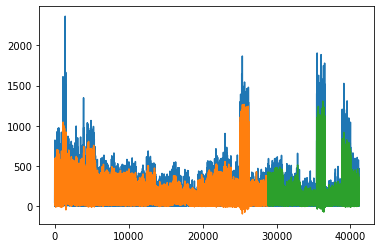

In [64]:
# Shift train predictions for plotting
# we must shift the predictions so that they align on the x-axis with the original dataset. 
predict_train_plot = np.empty_like(dataset)
predict_train_plot[:,:] = np.nan
predict_train_plot[seq_size:len(Train_predict)+seq_size, :] = Train_predict

# Shift test predictions for plotting
predict_test_plot = np.empty_like(dataset)
predict_test_plot[:,:] = np.nan
predict_test_plot[len(Train_predict)+(seq_size*2)+1:len(dataset)-1, :] = Test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.show()

## 2. Two LSTM layers with one hidden dense layer

In [65]:
# Reshape input to be [samples, time_steps, features]
train_x = np.reshape(Train_x, (Train_x.shape[0], 1, Train_x.shape[1]))
test_x = np.reshape(Test_x, (Test_x.shape[0], 1, Test_x.shape[1]))

########Set the LSTM model#######
print("LSTM Model")
model = Sequential()
model.add(LSTM(50, activation = 'relu', return_sequences = True, input_shape = (None, seq_size)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

LSTM Model
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 50)          12200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 34,065
Trainable params: 34,065
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.fit(train_x, Train_y, validation_data=(test_x, Test_y), verbose=2, epochs=100)

Train on 28800 samples, validate on 12338 samples
Epoch 1/100
 - 6s - loss: 0.0018 - val_loss: 0.0016
Epoch 2/100
 - 6s - loss: 0.0015 - val_loss: 0.0016
Epoch 3/100
 - 5s - loss: 0.0015 - val_loss: 0.0017
Epoch 4/100
 - 5s - loss: 0.0015 - val_loss: 0.0016
Epoch 5/100
 - 6s - loss: 0.0015 - val_loss: 0.0016
Epoch 6/100
 - 5s - loss: 0.0015 - val_loss: 0.0016
Epoch 7/100
 - 6s - loss: 0.0014 - val_loss: 0.0016
Epoch 8/100
 - 6s - loss: 0.0014 - val_loss: 0.0017
Epoch 9/100
 - 6s - loss: 0.0014 - val_loss: 0.0017
Epoch 10/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 11/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 12/100
 - 6s - loss: 0.0014 - val_loss: 0.0016
Epoch 13/100
 - 6s - loss: 0.0014 - val_loss: 0.0016
Epoch 14/100
 - 6s - loss: 0.0014 - val_loss: 0.0016
Epoch 15/100
 - 6s - loss: 0.0014 - val_loss: 0.0016
Epoch 16/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 17/100
 - 6s - loss: 0.0014 - val_loss: 0.0016
Epoch 18/100
 - 7s - loss: 0.0014 - val_loss: 0.0016
Epoch

In [69]:
# Make prediction
Train_predict = model.predict(train_x)
Test_predict = model.predict(test_x)

Train_predict = scaler.inverse_transform(Train_predict)
Train_y = scaler.inverse_transform([Train_y])
Test_predict = scaler.inverse_transform(Test_predict)
Test_y = scaler.inverse_transform([Test_y])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Train_y[0], Train_predict[:,0]))
print("Train score: %.2f RMSE" % (trainScore))

testScore = math.sqrt(mean_squared_error(Test_y[0], Test_predict[:,0]))
print("Test score: %.2f RMSE" % (testScore))

Train score: 81.31 RMSE
Test score: 95.16 RMSE


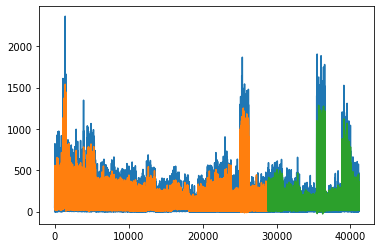

In [70]:
predict_train_plot = np.empty_like(dataset)
predict_train_plot[:,:] = np.nan
predict_train_plot[seq_size:len(Train_predict)+seq_size, :] = Train_predict

# Shift test predictions for plotting
predict_test_plot = np.empty_like(dataset)
predict_test_plot[:,:] = np.nan
predict_test_plot[len(Train_predict)+(seq_size*2)+1:len(dataset)-1, :] = Test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.show()

## 3. Bidirectional LSTM

For some sequence forecasting problems we may need LSTM to learn sequence in both forward and backward directions. To read more, visit this website: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/#:~:text=Bidirectional%20LSTMs%20are%20an%20extension,LSTMs%20on%20the%20input%20sequence

In [71]:
# Reshape input to be [samples, time_steps, features]
train_x = np.reshape(Train_x, (Train_x.shape[0], 1, Train_x.shape[1]))
test_x = np.reshape(Test_x, (Test_x.shape[0], 1, Test_x.shape[1]))

########Set the LSTM model#######
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None, seq_size)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 100)               24400     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 24,501
Trainable params: 24,501
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.fit(train_x, Train_y, validation_data=(test_x, Test_y), verbose=2, epochs=100)

Train on 28800 samples, validate on 12338 samples
Epoch 1/100
 - 6s - loss: 0.0018 - val_loss: 0.0017
Epoch 2/100
 - 5s - loss: 0.0015 - val_loss: 0.0016
Epoch 3/100
 - 6s - loss: 0.0015 - val_loss: 0.0016
Epoch 4/100
 - 5s - loss: 0.0015 - val_loss: 0.0016
Epoch 5/100
 - 6s - loss: 0.0015 - val_loss: 0.0016
Epoch 6/100
 - 6s - loss: 0.0014 - val_loss: 0.0016
Epoch 7/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 8/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 9/100
 - 5s - loss: 0.0014 - val_loss: 0.0017
Epoch 10/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 11/100
 - 5s - loss: 0.0014 - val_loss: 0.0015
Epoch 12/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 13/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 14/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 15/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 16/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 17/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 18/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch

In [74]:
# Make prediction
Train_predict = model.predict(train_x)
Test_predict = model.predict(test_x)

Train_predict = scaler.inverse_transform(Train_predict)
Train_y = scaler.inverse_transform([Train_y])
Test_predict = scaler.inverse_transform(Test_predict)
Test_y = scaler.inverse_transform([Test_y])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Train_y[0], Train_predict[:,0]))
print("Train score: %.2f RMSE" % (trainScore))

testScore = math.sqrt(mean_squared_error(Test_y[0], Test_predict[:,0]))
print("Test score: %.2f RMSE" % (testScore))

Train score: 83.35 RMSE
Test score: 92.97 RMSE


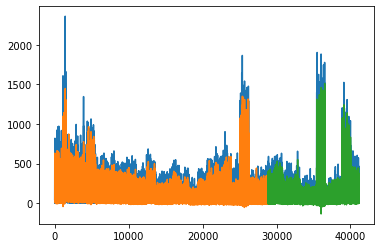

In [75]:
predict_train_plot = np.empty_like(dataset)
predict_train_plot[:,:] = np.nan
predict_train_plot[seq_size:len(Train_predict)+seq_size, :] = Train_predict

# Shift test predictions for plotting
predict_test_plot = np.empty_like(dataset)
predict_test_plot[:,:] = np.nan
predict_test_plot[len(Train_predict)+(seq_size*2)+1:len(dataset)-1, :] = Test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.show()

## 4. ConvLSTM

This layer expects input as a sequence of two-dimensional images, So, the shape of input data must be: [samples, timesteps, rows, columns, features]

In [53]:
# Reshape input to be [samples, time_steps, features]   
#seq_size=10
train_x = Train_x.reshape((Train_x.shape[0], 1, 1, 1, seq_size))
test_x = Test_x.reshape((Test_x.shape[0], 1, 1, 1, seq_size))


########Set the LSTM model#######
print("LSTM Model")
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape = (1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

LSTM Model
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          19200     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.fit(train_x, Train_y, validation_data=(test_x, Test_y), verbose=2, epochs=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 28800 samples, validate on 12338 samples
Epoch 1/100
 - 6s - loss: 0.0017 - val_loss: 0.0016
Epoch 2/100
 - 5s - loss: 0.0015 - val_loss: 0.0016
Epoch 3/100
 - 5s - loss: 0.0015 - val_loss: 0.0016
Epoch 4/100
 - 5s - loss: 0.0015 - val_loss: 0.0017
Epoch 5/100
 - 4s - loss: 0.0015 - val_loss: 0.0016
Epoch 6/100
 - 4s - loss: 0.0014 - val_loss: 0.0016
Epoch 7/100
 - 4s - loss: 0.0015 - val_loss: 0.0016
Epoch 8/100
 - 4s - loss: 0.0015 - val_loss: 0.0016
Epoch 9/100
 - 4s - loss: 0.0014 - val_loss: 0.0016
Epoch 10/100
 - 4s - loss: 0.0014 - val_loss: 0.0016
Epoch 11/100
 - 5s - loss: 0.0014 - val_loss: 0.0016
Epoch 12/100
 - 4s - loss: 0.0014 - val_loss: 0.0016
Epoch 13/100
 - 4s - loss: 0.0014 - val_loss: 0.0016
Epoch 14/100
 - 4s - loss: 0.0014 - val_loss: 0.0017
Epoch 15/100
 - 4s - loss: 0.0014 - val_loss: 0.0016
Epoch 16/100
 - 4s - loss: 0.0014 - val_loss: 0.0016
Epoch 17/100
 - 4

In [55]:
# Make prediction
Train_predict = model.predict(train_x)
Test_predict = model.predict(test_x)

Train_predict = scaler.inverse_transform(Train_predict)
Train_y = scaler.inverse_transform([Train_y])
Test_predict = scaler.inverse_transform(Test_predict)
Test_y = scaler.inverse_transform([Test_y])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Train_y[0], Train_predict[:,0]))
print("Train score: %.2f RMSE" % (trainScore))

testScore = math.sqrt(mean_squared_error(Test_y[0], Test_predict[:,0]))
print("Test score: %.2f RMSE" % (testScore))

Train score: 83.81 RMSE
Test score: 93.83 RMSE


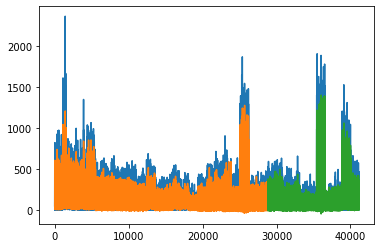

In [56]:
predict_train_plot = np.empty_like(dataset)
predict_train_plot[:,:] = np.nan
predict_train_plot[seq_size:len(Train_predict)+seq_size, :] = Train_predict

# Shift test predictions for plotting
predict_test_plot = np.empty_like(dataset)
predict_test_plot[:,:] = np.nan
predict_test_plot[len(Train_predict)+(seq_size*2)+1:len(dataset)-1, :] = Test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.show()